In [ ]:
!pip install razdel networkx nltk rouge==0.3.1 pymorphy2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re
import pymorphy2
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge
import razdel
from itertools import combinations
from nltk.tokenize import sent_tokenize, RegexpTokenizer
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import tqdm.notebook as tq

nltk.download('stopwords')
stop_words = stopwords.words('russian')
morph = pymorphy2.MorphAnalyzer()
%matplotlib inline
pd.options.display.max_columns = 200
plt.style.use('ggplot')
np.warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/DL project

Mounted at /content/drive
/content/drive/My Drive/DL project


# Data preparation

In [ ]:
data = pd.read_csv('news.csv')
data.tail()

,source,title,text,publication_date,rubric,subrubric,tags
21668,tjournal.ru,\n Россия прекратил...,\n\n \n \n \n \n \n...,1578056674,NaN,NaN,NaN
21669,tjournal.ru,\n Во Владивостоке ...,\n\n \n \n \n \n \n...,1577866951,NaN,NaN,NaN
21670,tjournal.ru,\n Дым от австралий...,\n\n \n \n \n \n \n...,1577864124,NaN,NaN,NaN
21671,tjournal.ru,\n Около 200 жителе...,\n\n \n \n \n \n \n...,1577894168,NaN,NaN,NaN
21672,tjournal.ru,\n Папа римский шлё...,\n\n \n \n \n \n \n...,1577893022,NaN,NaN,NaN


In [ ]:
data.isnull().sum()

source                  0
title                   3
text                    0
publication_date        0
rubric              17170
subrubric           17200
tags                 6921
dtype: int64

In [ ]:
data.source.value_counts()

ria.ru         14755
lenta.ru        4510
meduza.io       1538
tjournal.ru      870
Name: source, dtype: int64

In [ ]:
data.query('source == "tjournal.ru"').head(2)

,source,title,text,publication_date,rubric,subrubric,tags
20803,tjournal.ru,\n ФБК показал филь...,\n\n \n \n \n \n \n...,1598875929,NaN,NaN,NaN
20804,tjournal.ru,\n На улицах Минска...,\n\n \n \n \n \n \n...,1598795150,NaN,NaN,NaN


Удалим источник новостей "tjournal.ru", так как в нем некорректно отображаются тексты

In [ ]:
data = data.query('source != "tjournal.ru"')
data.shape

(20803, 7)

# Data Statistics

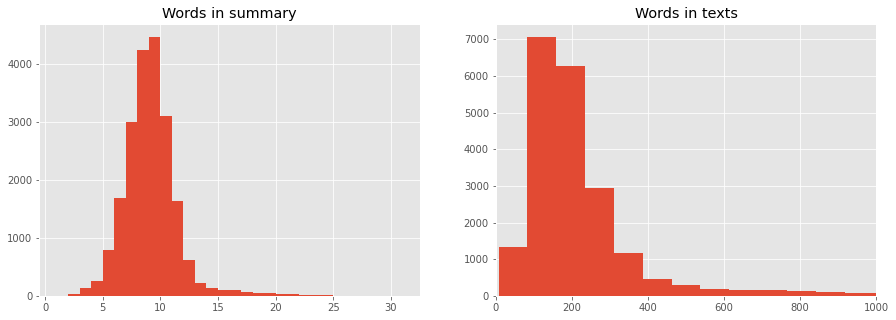

In [ ]:
headline_word_count = [len(i.split()) for i in data['title']]
text_word_count = [len(i.split()) for i in data['text']]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].hist(headline_word_count, 30)
axs[0].set_title('Words in summary')


axs[1].hist(text_word_count, 100)
axs[1].set_title('Words in texts')
axs[1].set_xlim([0, 1000])

plt.show()

In [ ]:
print('Среднее число слов в заголовке: {}'.format(np.mean(headline_word_count)))
print('Среднее число слов в полном тексте: {}'.format(np.mean(text_word_count)))

Среднее число слов в заголовке: 8.66591357015815
Среднее число слов в полном тексте: 239.74595010335048


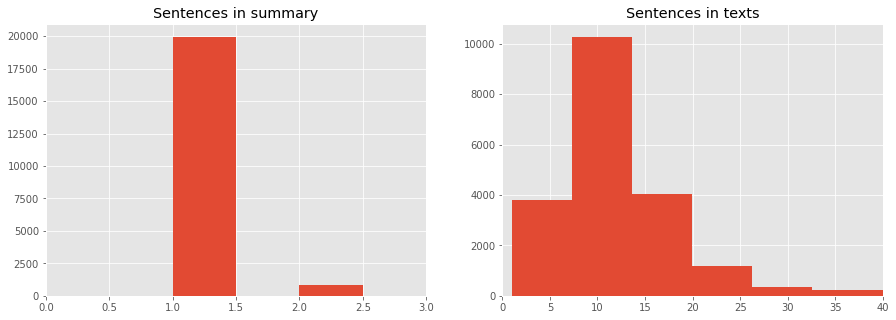

In [ ]:
headline_sent_count = []
text_sent_count = []

for i in data['title']:
  sentences = [sentence.text for sentence in razdel.sentenize(i)]
  headline_sent_count.append(len(sentences))

for i in data['text']:
  sentences = [sentence.text for sentence in razdel.sentenize(i)]
  text_sent_count.append(len(sentences))


fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].hist(headline_sent_count)
axs[0].set_title('Sentences in summary')
axs[0].set_xlim([0, 3])

axs[1].hist(text_sent_count, bins=100)
axs[1].set_title('Sentences in texts')
axs[1].set_xlim([0, 40])

plt.show()

In [ ]:
print('Среднее число предложений в заголовке: {}'.format(np.mean(headline_sent_count)))
print('Среднее число предложений в полном тексте: {}'.format(np.mean(text_sent_count)))

Среднее число предложений в заголовке: 1.0444647406624044
Среднее число предложений в полном тексте: 14.67778685766476


# Extract first sentence (baseline)

В качестве метрик оценки качества суммаризации будем использовать:
 * Bleu(аналог precision) 
 * Rouge(аналог recall)

In [ ]:
def calc_scores(titles, predictions):

    print("Количество заголовков:", len(titles))
    print("Пример заголовка:", titles[-1])
    print("Пример предсказания:", predictions[-1])

    bleu = corpus_bleu([[r] for r in titles], predictions)
    print("BLEU: {}".format(bleu))
        
    rouge = Rouge()
    scores = rouge.get_scores(predictions, titles, avg=True)
    print("ROUGE: {}".format(scores))

In [ ]:
def first_n_sentences(texts, summary, n=1, nrows=1000):

    titles = []
    predictions = []

    for i in tq.tqdm(range(nrows)):

      title = summary[i].lower()
      titles.append(title)

      sentences = [sentence.text for sentence in razdel.sentenize(texts[i])]
      #clean_sentences = [text_cleaner(sen) for sen in sentences]

      prediction = " ".join(sentences[:n])
      predictions.append(prediction)

    return titles, predictions

In [ ]:
titles, predictions = first_n_sentences(data.text, data.title, n=1)

In [ ]:
calc_scores(titles, predictions)

Количество заголовков: 1000
Пример заголовка: оценены потери россии от введения нового налога в европе
Пример предсказания: Россия может потерять больше 50 миллиардов евро в 2022-2030 годах в случае введения нового углеродного налога в Европе.
BLEU: 0.2864671080219227
ROUGE: {'rouge-1': {'f': 0.27948952364438145, 'p': 0.22201018893102767, 'r': 0.4057042180042181}, 'rouge-2': {'f': 0.14979736222963685, 'p': 0.11916239792618673, 'r': 0.21973034743034742}, 'rouge-l': {'f': 0.229720398941948, 'p': 0.2106841200386862, 'r': 0.38408296148296167}}


# Textrank with sentence similarity

Создадим главную функцию для предобработки текста:

In [ ]:
def text_cleaner(text, lemm=True):
    """
    Преобразование исходного текста
    :param text: входной текст
    :param lemm: лемматизация
    :return: обработанный текст
    """
    new_string = text.lower()  # lower register
    new_string = re.sub("[^а-яА-Я]", " ", new_string)  # delete all except russian
    # removing stop words
    tokens = [w for w in new_string.split() if not w in stop_words]
    # removing short words
    words = [w for w in tokens if len(w) >= 3]
    # lemmatization
    if lemm:
        words = [morph.parse(w)[0].normal_form for w in words]

    return ' '.join(words).strip()

In [ ]:
#функция схожести предложений(кол-во схожих слов на длину предложений)
def similarity(s1, s2):
    s1 = set(s1)
    s2 = set(s2)
    if not len(s1) or not len(s2):
        return 0.0
    return len(s1.intersection(s2))/(1.0 * (len(s1) + len(s2)))

#обработка текста
def textrank_words(text):

    #разбиваем текст на предложения
    sentences = [sentence.text for sentence in razdel.sentenize(text)]
    #очищаем предложения
    clean_sentences = [text_cleaner(sen) for sen in sentences]
    #разбиваем предложения на слова
    words = [[token.text for token in razdel.tokenize(sentence)] for sentence in clean_sentences]
    
    #для каждого предложения считаем схожесть с другими
    pairs = combinations(range(len(sentences)), 2)
    scores = [(i, j, similarity(words[i], words[j])) for i, j in pairs]
    scores = filter(lambda x: x[2], scores)
    
    #строим граф, считаем пейджранки и сортируем по ним
    g = nx.Graph()
    g.add_weighted_edges_from(scores)
    pr = nx.pagerank(g)

    return sorted(((i, pr[i], s) for i, s in enumerate(sentences) if i in pr),
                  key=lambda x: pr[x[0]], reverse=True)

#выводим самое популярное предложение
def extract_1(text, n=1):
    tr = textrank_words(text)
    top_n = sorted(tr[:n])
    return ' '.join(x[2] for x in top_n)

In [ ]:
def calc_text_rank_score(texts, summary, extractor, n=1, nrows=1000):
    titles = []
    predictions = []

    for i in tq.tqdm(range(nrows)):
      title = summary[i].lower()
      titles.append(title)

      prediction = extractor(texts[i])
      predictions.append(prediction)

    return titles, predictions

In [ ]:
titles, predictions = calc_text_rank_score(data.text, data.title, extract_1)

In [ ]:
calc_scores(titles, predictions)

Количество заголовков: 1000
Пример заголовка: оценены потери россии от введения нового налога в европе
Пример предсказания: В таком случае российские экспортеры заплатят 6 миллиардов до 2030 года.
BLEU: 0.22320249186509
ROUGE: {'rouge-1': {'f': 0.17086805390195114, 'p': 0.13416338802823716, 'r': 0.2546069291819293}, 'rouge-2': {'f': 0.07492615344672812, 'p': 0.058749277266587074, 'r': 0.11248272005772018}, 'rouge-l': {'f': 0.1369249337829199, 'p': 0.1258226449141299, 'r': 0.23838231490731498}}


In [ ]:
titles[:5]

['синий богатырь',
 'загитова согласилась вести «ледниковый период»',
 'объяснена опасность однообразного питания',
 '«предохраняться? а\xa0зачем?»',
 'ефремов систематически употреблял наркотики']

In [ ]:
predictions[:5]

['Об ошибке стало известно почти сразу, однако менять имя было поздно: Стаханов уже стал всесоюзной знаменитостью под именем Алексей и привлек внимание советских властей, в том числе лично товарища Сталина.',
 'Олимпийская чемпионка по фигурному катанию  Алина Загитова  согласилась стать ведущей шоу «Ледниковый период».',
 'По словам диетолога, разнообразное питание благоприятно влияет на микробиоту, которая помогает максимально усваивать из\xa0продуктов все полезные вещества.',
 'Одной из самых успешных оказалась Ангелина из последней серии первого сезона — девушка, которая осталась матерью-одиночкой, стала активно вкладываться в свой Instagram на волне популярности шоу.',
 'Позднее в  правоохранительных органах  пояснили, что это остаточные следы наркотиков, и подчеркнули, что их Ефремов «когда-то ранее употреблял».']

# TextRank using vector representation of words

In [ ]:
# очищаем полные тексты
cleaned_text = [text_cleaner(i) for i in tq.tqdm(data.text)]

In [ ]:
# разбиваем тексты на слова
data_tok = [[token.text for token in razdel.tokenize(text)] for text in tq.tqdm(cleaned_text)]

In [ ]:
n_words = sum(len(doc) for doc in data_tok)
n_unique_words = len(np.unique([word for doc in data_tok for word in doc]))
print(f'В предложениях {n_words} слов, уникальных — {n_unique_words}')

В предложениях 3403916 слов, уникальных — 73240


## Word2Vec

In [ ]:
%%time
# Обучим модель word2vec на имеющихся текстах
from gensim.models import Word2Vec
model_w2v = Word2Vec(data_tok, 
                     size=100,      # размер эмбеддинга
                     min_count=2,  # минимальная допустимая частота слова для включения в словарь
                     window=5).wv  # размер контекста — 5 слов

CPU times: user 1min 16s, sys: 518 ms, total: 1min 16s
Wall time: 45.9 s


In [ ]:
import pickle

with open('word2vec.pickle', 'wb') as f:
    pickle.dump(model_w2v, f) 

In [ ]:
with open('word2vec.pickle', 'rb') as file:
    model_w2v = pickle.load(file)

In [ ]:
print(f'В модели {len(model_w2v.vocab)} слов')

В модели 47194 слов


In [ ]:
model_w2v.get_vector('футбол')

array([ 0.26213923,  0.03603933, -0.2704333 ,  0.31103584, -0.3474833 ,
        0.00560125, -0.50637674,  0.06634782, -0.3273839 ,  0.20803618,
       -0.12899475, -0.25118157,  0.34557974, -0.2957838 , -0.61382437,
        0.51075023,  0.2559366 ,  0.2558219 , -0.46683073,  0.42777494,
        0.6052743 , -0.39799854, -0.38024786, -0.62335706, -0.23973002,
        0.749786  , -0.34675792, -0.08385407,  0.7742826 , -1.241985  ,
       -0.18817014, -0.41431007,  0.2686036 ,  0.7485593 ,  0.3965559 ,
       -0.29485542,  0.24505635,  0.7417829 ,  0.022939  ,  0.27499264,
       -0.12889147,  0.11684402,  0.44622043, -0.13988595,  0.05089089,
       -0.1565145 , -0.17854458, -0.49186376, -0.15969329, -0.6727083 ,
       -0.43411964,  0.4560589 ,  0.18684162,  0.7165174 , -0.02073683,
       -0.48852476, -0.15813953,  0.6099713 ,  0.13480113,  0.21764775,
        0.05265476,  0.60065836, -0.32388023, -0.42418367, -0.2145167 ,
        0.04443614,  0.20583442, -0.27683595,  0.45158812, -0.22

In [ ]:
model_w2v.most_similar(positive=['путин'])

[('зеленский', 0.7603131532669067),
 ('джабар', 0.6855653524398804),
 ('колокольцев', 0.6753491163253784),
 ('колоколец', 0.6723846197128296),
 ('потанин', 0.6581317186355591),
 ('гриценко', 0.6568673253059387),
 ('эрдоган', 0.6509226560592651),
 ('жириновский', 0.6460608839988708),
 ('макей', 0.6436161398887634),
 ('мединский', 0.6217626333236694)]

## TSNE for top 1000 words

In [ ]:
words = sorted(model_w2v.vocab.keys(), 
               key=lambda word: model_w2v.vocab[word].count,
               reverse=True)[:1000]

words[:10]

['год',
 'который',
 'человек',
 'новость',
 'риа',
 'россия',
 'это',
 'москва',
 'страна',
 'коронавирус']

In [ ]:
# Достанем векторы всех слов
word_vectors = np.array([model_w2v.get_vector(word) for word in words])
word_vectors.shape

(1000, 100)

In [ ]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

In [ ]:
from sklearn.manifold import TSNE

word_tsne = TSNE(n_components=2, n_iter=1000, metric='cosine').fit_transform(word_vectors)
word_tsne = (word_tsne - word_tsne.mean(axis=0)) / word_tsne.std(axis=0)

In [ ]:
draw_vectors(word_tsne[:, 0], word_tsne[:, 1], color='blue', token=words)

Figure(id='1112', ...)

## Model

In [ ]:
import pickle 

with open('word2vec.pickle', 'rb') as file:
    model_w2v = pickle.load(file)

In [ ]:
def textrank_vectors(text):

    #разбиваем текст на предложения
    sentences = [sentence.text for sentence in razdel.sentenize(text)]

    #очищаем предложения
    clean_sentences = [text_cleaner(sen) for sen in sentences]

    #разбиваем предложения на слова
    sentence_words = [[token.text for token in razdel.tokenize(sentence)] for sentence in clean_sentences]
    
    #вычисляем вектора для каждого предложения в тексте
    sentence_vectors = []
    for words in sentence_words:
        v = np.zeros((100,))
        if len(words)!=0:
            for w in words:   
                try:
                    v += model_w2v[w]
                except:
                    v += np.zeros((100,))
                    
            v = v/len(words)
            sentence_vectors.append(v)
        else:
            sentence_vectors.append(v)
    
    #матрица похожести
    sim_mat = np.zeros((len(sentences), len(sentences)))
    for i in range(len(sentences)):
        for j in range(len(sentences)):
            if i != j:
                sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]
    
    #строим граф, считаем пейджранки и сортируем по ним
    graph = nx.from_numpy_array(sim_mat)
    pr = nx.pagerank_numpy(graph)

    return sorted(((i, pr[i], s) for i, s in enumerate(sentences) if i in pr),
                  key=lambda x: pr[x[0]], reverse=True)


#выводим самое популярное предложение для заголовка
def extract_2(text, n=1):
    tr = textrank_vectors(text)
    top_n = sorted(tr[:n])
    return ' '.join(x[2] for x in top_n)

In [ ]:
extract_2(data.text[284])

'Плоды растения также полезны для желудочно-кишечного тракта.'

In [ ]:
titles, predictions = calc_text_rank_score(data.text, data.title, extract_2)

In [ ]:
calc_scores(titles, predictions)

Количество заголовков: 1000
Пример заголовка: оценены потери россии от введения нового налога в европе
Пример предсказания: Россия может потерять больше 50 миллиардов евро в 2022-2030 годах в случае введения нового углеродного налога в Европе.
BLEU: 0.16891520083163006
ROUGE: {'rouge-1': {'f': 0.11673201664557427, 'p': 0.09003632448837783, 'r': 0.18277521367521393}, 'rouge-2': {'f': 0.042410165735394065, 'p': 0.03322059272403748, 'r': 0.06420909090909098}, 'rouge-l': {'f': 0.09170904607133533, 'p': 0.08455509287987027, 'r': 0.17110128760128782}}
